In [1]:
import re
import string

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('inputs/Dimension-covid.csv')
data.head()

,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date,Active years,Phase,Conditions,...,Gender,Registry,Investigators/Contacts,Sponsors/Collaborators,GRID IDs,Country of Sponsor/Collaborator,Collaborating Funders,Funder Country,Source Linkout,Dimensions URL
0,2021-06-04,NCT04912934,The Relationship Between Coronavirus Anxiety L...,The Relationship Between COVID-19 Anxiety Leve...,COVID-19,The aim was to determine the coronavirus anxie...,2020-06-20,2020,NaN,COVID-19; Emotional Eating; Metabolic Syndrome,...,All,ClinicalTrials.gov,Dilek Küçük Alemdar,Ordu University,grid.412366.4,Turkey,NaN,NaN,https://clinicaltrials.gov/show/NCT04912934,https://app.dimensions.ai/details/clinical_tri...
1,2021-06-04,NCT04912921,Effect of Palmitoylethanolamide on Proinflamma...,Effect of Palmitoylethanolamide on Proinflamma...,NaN,This is a randomized controlled trial to exami...,2020-10-20,2020; 2021; 2022,NaN,COVID19; Inflammation,...,All,ClinicalTrials.gov,NaN,Arizona State University,grid.215654.1,United States,NaN,NaN,https://clinicaltrials.gov/show/NCT04912921,https://app.dimensions.ai/details/clinical_tri...
2,2021-06-04,NCT04912895,Detection of SARS-CoV-2 RNA and Biomarkers in ...,Detection of SARS-CoV-2 RNA in Coughed Droplet...,NaN,The purpose of this study is to learn how to b...,2021-04-14,2021; 2022,NaN,Covid19,...,All,ClinicalTrials.gov,Larry Anderson,Emory University Hospital Midtown; Emory Unive...,grid.411929.6; grid.412162.2; grid.189967.8; g...,United States; United States; United States; U...,NaN,NaN,https://clinicaltrials.gov/show/NCT04912895,https://app.dimensions.ai/details/clinical_tri...
3,2021-06-04,NCT04912817,Pain Rehabilitation Virtual Reality (PR-VR) At...,PR-VR At-home Program During and After COVID-19,NaN,Poorly controlled chronic pain in teens can im...,2021-09-01,2021; 2022,NaN,"Pain, Chronic",...,All,ClinicalTrials.gov,Jennifer Stinson,Hospital for Sick Children; Stanford University,grid.42327.30; grid.168010.e,Canada; United States,Hospital for Sick Children,Canada,https://clinicaltrials.gov/show/NCT04912817,https://app.dimensions.ai/details/clinical_tri...
4,2021-06-04,NCT04912804,Perceived Health After Hospitalization for COV...,Perceived Health After Hospitalization for COV...,PRO-COVID,There are currently no precise data available ...,2020-06-30,2020; 2021,NaN,"COVID-19, Post-hospitalization, Disease Impact",...,All,ClinicalTrials.gov,NaN,Centre Hospitalier Universitaire Dijon Bourgogne,grid.31151.37,France,NaN,NaN,https://clinicaltrials.gov/show/NCT04912804,https://app.dimensions.ai/details/clinical_tri...


In [3]:
data_nan = (data.isnull().sum() / len(data)) * 100
data_nan = data_nan.drop(data_nan[data_nan == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_nan})
missing_data.head(5)

,Missing Ratio
Collaborating Funders,83.123945
Funder Country,83.123945
Acronym,66.641665
Phase,60.285018
Intervention,26.973561


Text(0.5, 1.0, 'Percent missing data by feature in the dataset')

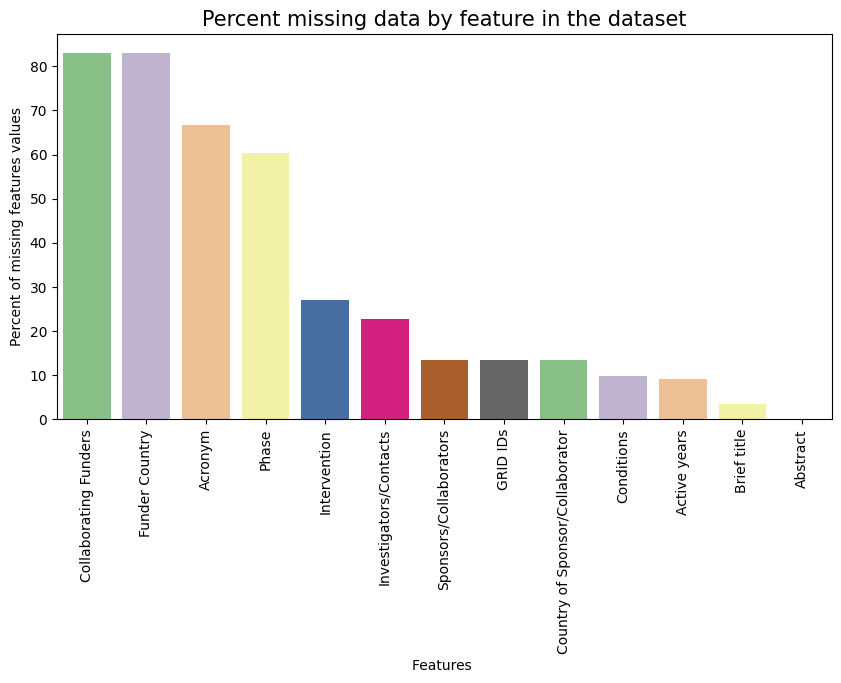

In [4]:
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')
sns.barplot(x=data_nan.index, y=data_nan, palette=("Accent"))
plt.xlabel('Features ', fontsize=10)
plt.ylabel('Percent of missing features values', fontsize=10)
plt.title('Percent missing data by feature in the dataset', fontsize=15)

In [5]:
print('Total numbers of rows in data {} and features are {}'.format(data.shape[0], data.shape[1]))

Total numbers of rows in data 10666 and features are 21


In [6]:
data['Abstract'][0]

'The aim was to determine the coronavirus anxiety levels and emotional eating status of cases with diagnosis of MetS according to diagnostic criteria published by the International Diabetic Federation (IDF) in 2005 and healthy individuals with similar BMI to MetS subjects.\n\nDetailed Description\nThe aim was to determine the coronavirus anxiety levels and emotional eating status of cases with diagnosis of MetS according to diagnostic criteria published by the International Diabetic Federation (IDF) in 2005 and healthy individuals with similar BMI to MetS subjects. This study was completed with the descriptive, cross-sectional and relational screening model. The full sampling method was used in the study. The study was completed with 105 individuals with metabolic syndrome attending the diet clinic and 109 healthy individuals without MetS diagnosis also attending the diet clinic. Collection of data used anthropometric measurements and biochemical findings, blood pressure and a survey f

In [7]:
## Drop the rows where the abstract is Nan.
data.dropna(subset=['Abstract'], inplace=True)

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [9]:
# function to remove all urls
from tqdm import tqdm
class Text_cleaning:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        
    def remove_urls(self, text):
        try:
            new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
            return new_text
        except:
            return text

    # make all text lowercase
    def text_lowercase(self, text):
        try:
            return text.lower()
        except:
            return text
    
    # remove numbers
    def remove_numbers(self, text):
        try:
            result = re.sub(r'\d+', '', text)
            return result
        except:
            return text
    
    # remove punctuation
    def remove_punctuation(self, text):
        try:
            translator = str.maketrans('', '', string.punctuation)
            return text.translate(translator)
        except:
            return text
    
    # tokenize
    def tokenize(self, text):
        try:
            text = word_tokenize(text)
            return text
        except:
            return text
    
    # remove stopwords
    
    def remove_stopwords(self, text):
        try:
            text = [i for i in text if not i in self.stop_words]
            return text
        except:
            return text
    
    # lemmatize Words 
    
    def lemmatize(self, text):
        try:
            text = [self.lemmatizer.lemmatize(token) for token in text]
            return text
        except:
            return text

    #Creating one function so that all functions can be applied at once
    def preprocessing(self, data, columns=None, text=None):
        if text is None:
            for i in tqdm(range(data.shape[0])):
                text = data.iloc[i][columns]
                text = self.remove_urls(text)
                text = self.remove_numbers(text)
                text = self.text_lowercase(text)
                text = self.remove_punctuation(text)
                text = self.tokenize(text)
                text = self.remove_stopwords(text)
                text = self.lemmatize(text)
                text = ' '.join(text)
                text = text.replace('\n',' ') 
                data.iloc[i][columns] = text
            data[columns] = data[columns].apply(str)
            return data
        else:
            text = self.remove_urls(text)
            text = self.remove_numbers(text)
            text = self.text_lowercase(text)
            text = self.remove_punctuation(text)
            text = self.tokenize(text)
            text = self.remove_stopwords(text)
            text = self.lemmatize(text)
            text = ' '.join(text)
            text = text.replace('\n',' ') 
            return text
            

In [10]:
text_clean = Text_cleaning()
data = text_clean.preprocessing(data, columns = 'Abstract')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10664/10664 [00:12<00:00, 827.24it/s]


In [11]:
data['Abstract'][0]

'aim determine coronavirus anxiety level emotional eating status case diagnosis mets according diagnostic criterion published international diabetic federation idf healthy individual similar bmi mets subject detailed description aim determine coronavirus anxiety level emotional eating status case diagnosis mets according diagnostic criterion published international diabetic federation idf healthy individual similar bmi mets subject study completed descriptive cross sectional relational screening model full sampling method used study study completed individual metabolic syndrome attending diet clinic healthy individual without mets diagnosis also attending diet clinic collection data used anthropometric measurement biochemical finding blood pressure survey form coronavirus anxiety scale ca emotional eating scale ee'

In [12]:
from collections import Counter
cnt = Counter()
for text in data["Abstract"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('patient', 38457),
 ('covid', 38211),
 ('study', 31963),
 ('group', 12771),
 ('treatment', 12471),
 ('day', 12337),
 ('sars', 11600),
 ('cov', 11540),
 ('clinical', 11507),
 ('disease', 11395)]

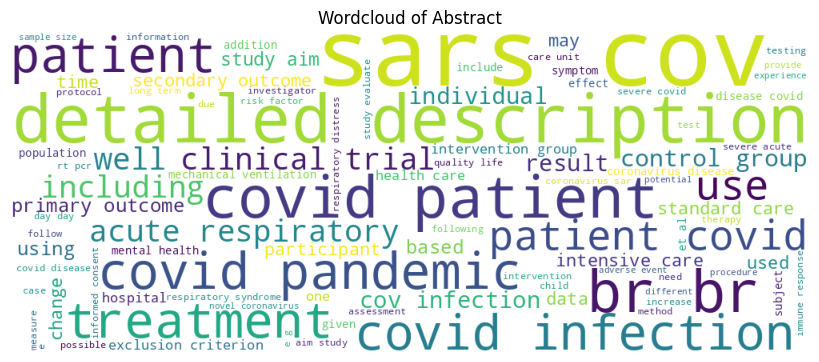

In [13]:
#Final word cloud after all the cleaning and pre-processing
from wordcloud import WordCloud
from nltk.corpus import stopwords
wordcloud = WordCloud(width = 1000, height = 400, 
            background_color ='white',  
            min_font_size = 10).generate(" ".join(data['Abstract'].astype(str))) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('Wordcloud of Abstract')
plt.tight_layout(pad = 0) 

plt.show() 

## Title

In [14]:
#Applying preprocessing and removing '\n' character
data = text_clean.preprocessing(data, 'Title')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10664/10664 [00:02<00:00, 4843.94it/s]


In [15]:
data['Title'][0]

'The Relationship Between Coronavirus Anxiety Level and Emotional Eating in Individuals With Metabolic Syndrome'

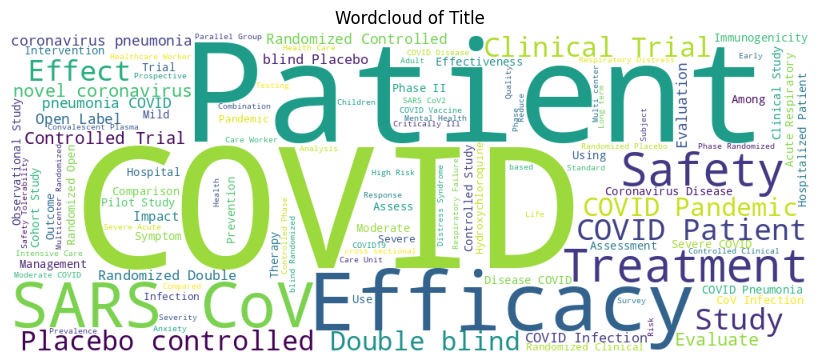

In [16]:
#Final word cloud after all the cleaning and pre-processing
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 400, 
            background_color ='white', 
            min_font_size = 10).generate(" ".join(data['Title'].astype(str))) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('Wordcloud of Title')
plt.tight_layout(pad = 0) 

plt.show() 

In [17]:
import gensim
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [18]:
x=[word_tokenize(word) for word in data.Abstract ]   #Tokenizing data for training purpose

# Skip gram

In [59]:
# training the model

skipgram = Word2Vec(x, vector_size =50, window = 3, min_count=2,sg = 1)
print(skipgram)
skipgram.save('models/skipgramx1.bin')

Word2Vec<vocab=24876, vector_size=50, alpha=0.025>


In [60]:
# Loading the model
skipgram = Word2Vec.load('models/skipgramx1.bin')

In [61]:
# Similar words - skipgram

skipgram.wv.most_similar(positive=['corona'],topn=10)

[('coronavirus', 0.865572452545166),
 ('novel', 0.8009514808654785),
 ('belongs', 0.7944085001945496),
 ('covid', 0.7845943570137024),
 ('virulent', 0.7811598181724548),
 ('pandemia', 0.7777072191238403),
 ('tough', 0.7720644474029541),
 ('covs', 0.7640461325645447),
 ('causative', 0.7560394406318665),
 ('zoonotic', 0.7538752555847168)]

In [62]:
# Similar words - skipgram

skipgram.wv.most_similar(positive=['corona'],topn=10)

[('coronavirus', 0.865572452545166),
 ('novel', 0.8009514808654785),
 ('belongs', 0.7944085001945496),
 ('covid', 0.7845943570137024),
 ('virulent', 0.7811598181724548),
 ('pandemia', 0.7777072191238403),
 ('tough', 0.7720644474029541),
 ('covs', 0.7640461325645447),
 ('causative', 0.7560394406318665),
 ('zoonotic', 0.7538752555847168)]

In [63]:
skipgram.wv.most_similar(positive=['patient'],topn=10)

[('subject', 0.8228190541267395),
 ('moderately', 0.8087784647941589),
 ('acutely', 0.807763397693634),
 ('individual', 0.7946636080741882),
 ('picu', 0.7934961318969727),
 ('inpatient', 0.7894273996353149),
 ('surgically', 0.7739956378936768),
 ('lymphocytopenia', 0.7709656953811646),
 ('participant', 0.7665682435035706),
 ('microbiologically', 0.7665524482727051)]

In [64]:
X = skipgram.wv[skipgram.wv.index_to_key]    #stroing arrays of all words
pca = PCA(n_components=2)                    #applying PCA to convert data into two dimensions
result = pca.fit_transform(X)

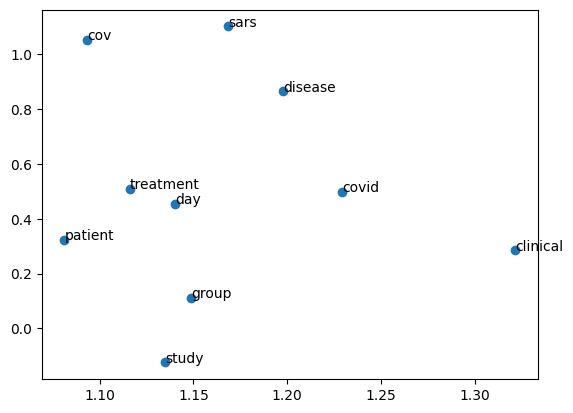

In [65]:
#words embeddings on the plot to check 2-D representation of each word
pyplot.scatter(result[:10, 0], result[:10, 1])
words = list(skipgram.wv.index_to_key)
for i, word in enumerate(words[:10]):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [66]:

def get_mean_vector(word2vec_model, words):
    # remove out-of-vocabulary words
    words = [word for word in text_clean.tokenize(words) if word in list(word2vec_model.wv.index_to_key)] #if word is in vocab 
    if len(words) >= 1:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.array([0]*100)


In [67]:
K1=[]                                     #defining empty list
for i in data.Abstract:
    K1.append(list(get_mean_vector(skipgram, i)))     #appending array to the list
    
    
K11=pd.DataFrame(K1)    # Saving vectors of each abstract in data frame so that we can use directly while running code again
K11.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.089873,-0.094369,0.073069,-0.023648,0.004745,-0.356759,0.470693,0.634980,-0.499220,0.168518,...,0.274719,-0.298785,0.006323,0.104576,0.533808,-0.181371,0.070819,-0.340930,0.143351,0.224206
1,-0.037627,-0.173336,0.021844,-0.042829,-0.017887,-0.264718,0.546345,0.656557,-0.357103,0.042688,...,0.279472,-0.157596,0.210579,0.103901,0.559711,-0.172792,0.234004,-0.223340,0.208356,0.370043
2,0.000605,-0.128829,-0.030548,-0.019552,-0.179447,-0.332540,0.598001,0.729193,-0.342705,-0.055138,...,0.312418,-0.340417,0.179704,0.036397,0.668073,-0.034067,0.155285,-0.369379,0.141908,0.391889
3,0.189674,-0.336971,0.083518,0.058825,-0.201955,-0.157478,0.429584,0.542197,-0.587529,0.179635,...,0.393186,-0.187273,0.146295,0.111954,0.503344,-0.258906,0.149829,-0.091163,0.158053,0.526574
4,0.149876,-0.273868,-0.001843,0.156017,-0.153735,-0.274272,0.438964,0.693998,-0.650714,0.243161,...,0.425383,-0.192694,0.078947,0.028858,0.500325,-0.324389,0.202581,-0.334441,0.254077,0.245190


In [68]:
K11 = K11.transpose()

In [69]:
K11.shape

(50, 10664)

In [70]:
data.shape

(10664, 22)

In [31]:
skipgram_vectors=[]                          #transforming dataframe into required array like structure as we did in above step
for i in range(data.shape[0]):
    skipgram_vectors.append(K11[i])

In [57]:
skipgram_vectors_array = np.array(skipgram_vectors)

# Save the NumPy array
np.save('models/skipgram_vectors.npy', fast_vectors_array)
#fast_vectors.save('models/fast_vectors.npy')
skipgram_vectors = np.load('models/skipgram_vectors.npy')

# Fast Text

In [33]:
vector_size=100   #defining vector size for each word

In [34]:
FastText=FastText(x,vector_size=100, window=2, min_count=2, workers=5, min_n=1, max_n=2,sg=1)
FastText.save('models/FastText.bin')    #Saving our model
FastText = Word2Vec.load('models/FastText.bin')  #Loading our pretrained model

In [35]:
# Similar words - fasttext

FastText.wv.most_similar(positive=['lung'],topn=10)

[('lungiq', 0.7621306777000427),
 ('leung', 0.7257423400878906),
 ('silicovilung', 0.6822967529296875),
 ('sung', 0.6803723573684692),
 ('lubricating', 0.6778289675712585),
 ('clungene', 0.6751940250396729),
 ('volunteering', 0.6692583560943604),
 ('ltigung', 0.6589511632919312),
 ('laung', 0.6548717617988586),
 ('pulmonary', 0.6512830853462219)]

In [36]:
FastText.wv.most_similar(positive=['breathing'],topn=10)

[('rebreathing', 0.9151287078857422),
 ('breaching', 0.9082427620887756),
 ('breathe', 0.8783654570579529),
 ('breaking', 0.8760102987289429),
 ('breath', 0.8599046468734741),
 ('breathed', 0.8574958443641663),
 ('bathing', 0.8548488616943359),
 ('heating', 0.8405588269233704),
 ('babybreathe', 0.8395075798034668),
 ('eating', 0.8375762701034546)]

In [37]:
#same thing as above but with fasttext model
X_fast = FastText.wv[FastText.wv.index_to_key]
pca = PCA(n_components=2)
result_fast = pca.fit_transform(X_fast)

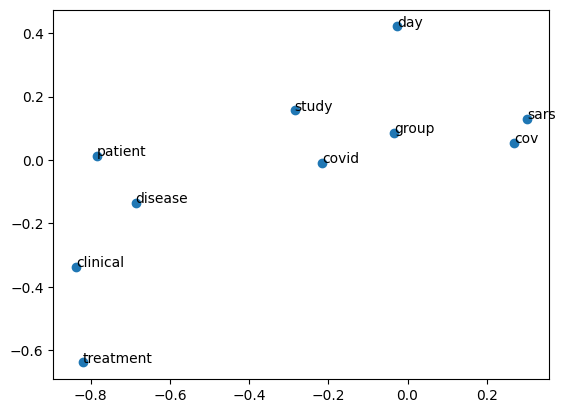

In [38]:
pyplot.scatter(result_fast[:10, 0], result_fast[:10, 1])
words = list(FastText.wv.index_to_key)
for i, word in enumerate(words[:10]):
    pyplot.annotate(word, xy=(result_fast[i, 0], result_fast[i, 1]))
pyplot.show()

In [39]:
data.reset_index(inplace = True)

In [40]:
#function to take average of all vectors of each word in abstract, so that each abstract can represent (1,100) dimensional vector
from tqdm import tqdm
K1 = []      #creating list to store vector representation of each abstract

for i in tqdm(range(data.shape[0])):       #iterating through all abstract
    K=np.zeros([vector_size,1])    #creating empty array of size (vec_size,1) to add vector representation of each word
    count=0                        #creating count to check how many words are used from abstract
    text = data['Abstract'][i]
    if len(text)>0:
        for word in word_tokenize(text):   #iterating through all words in given abstract
            if word in list(FastText.wv.index_to_key):      #if word exists in vocab , increase count by 1 and add array of given words in our defined array K
                count+=1
                K+=FastText.wv[word].reshape(vector_size,1)
        K=K/count                                        #taking average of given array
        K1.append(list(K))                               #appending vector of given abstract to the initial defined list
K1_array=np.array(K1)
K1_array=K1_array.reshape(data.shape[0],vector_size)   #converting into array of shape(no. of rows, vector_size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10664/10664 [02:29<00:00, 71.41it/s]


In [41]:
K11=pd.DataFrame(K1).transpose()

In [44]:

def get_mean_vector(word2vec_model, words):
    # remove out-of-vocabulary words
    words = [word for word in text_clean.tokenize(words) if word in list(word2vec_model.wv.index_to_key)] #if word is in vocab 
    if len(words) >= 1:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.array([0]*100)

In [45]:
K_fast=[]                                     #defining empty list
for i in data.Abstract:
    K_fast.append(list(get_mean_vector(FastText, i)))     #appending array to the list
    
K11=pd.DataFrame(K_fast).transpose()    # Saving vectors of each abstract in data frame so that we can use directly while running code again
#K11.to_csv('FastText-vec.csv')

In [46]:
K11.head()

,0,1,2,3,4,5,6,7,8,9,...,10654,10655,10656,10657,10658,10659,10660,10661,10662,10663
0,-0.369374,-0.392916,-0.443708,-0.307071,-0.341993,-0.460612,-0.387114,-0.397919,-0.413374,-0.391874,...,-0.322638,-0.388359,-0.315388,-0.358413,-0.373353,-0.389036,-0.382656,-0.342966,-0.450776,-0.434627
1,0.173420,0.224347,0.330942,0.206261,0.149332,0.161096,0.139136,0.261039,0.168621,0.217738,...,0.228313,0.165147,0.181997,0.251498,0.176823,0.204254,0.203742,0.195090,0.276743,0.283912
2,-0.507120,-0.683633,-0.751344,-0.468438,-0.454167,-0.624142,-0.487683,-0.639429,-0.695239,-0.632224,...,-0.537846,-0.559955,-0.477309,-0.688643,-0.688200,-0.623358,-0.551556,-0.468555,-0.697813,-0.691022
3,0.053974,0.152349,0.080042,0.045562,0.044096,0.046616,0.086623,0.145134,0.146070,0.156940,...,0.036100,0.089475,0.106674,0.100151,0.077101,0.096836,0.104163,0.060903,0.064906,0.055214
4,0.146396,0.111016,0.147334,0.172690,0.193466,0.133347,0.090782,0.117541,0.132598,0.107233,...,0.181024,0.107881,0.120482,0.114520,0.068318,0.102036,0.170399,0.187375,0.102225,0.101712


In [47]:
fast_vectors=[]                          #transforming dataframe into required array like structure as we did in above step
for i in range(data.shape[0]):
    fast_vectors.append(K11[i])

In [52]:
fast_vectors_array = np.array(fast_vectors)

# Save the NumPy array
np.save('models/fast_vectors.npy', fast_vectors_array)
#fast_vectors.save('models/fast_vectors.npy')

In [71]:
fast_vectors = np.load('models/fast_vectors.npy')

In [48]:
#defining function to define cosine similarity

from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b)) 

In [49]:
#Preprocessing input, because input should be in same form as training data set

def preprocessing_input(query,word2vec_model):
    query=text_clean.preprocessing(data, text =query)
    query=query.replace('\n',' ')
    K=get_mean_vector(word2vec_model,query)
    return K   

In [55]:
#function to return top n similar results

#query - input query
# p - average vectors for all abs
#df1 - original

def top_n(query, p, data, model):    
    print(query)
    
    query=preprocessing_input(query,model)    #preprocessing input to list of vectors
                                    
    x=[]
    #Converting cosine similarities of overall data set with input queries into LIST
    for i in range(len(p)):
        x.append(cos_sim(query,p[i]))
    
    
 #store list in tmp to retrieve index
    tmp=list(x)
    
 #sort list so that largest elements are on the far right
    
    res = sorted(range(len(x)), key = lambda sub: x[sub])[-5:]
    sim=[tmp[i] for i in reversed(res)]
    print(sim)
 #get index of the 10 or n largest element
    L=[]
    for i in reversed(res):
    
        L.append(i)
    return data.iloc[L, [1, 2, 3, 4, 5, 6, 7]],sim     #returning dataframe (only id,title,abstract ,publication date)

In [58]:
# skipgram model

#Input your search query here

Query = "lung failure"

Results,sim = top_n(Query, skipgram_vectors, data, skipgram)
Results

lung failure


ValueError: shapes (50,) and (100,) not aligned: 50 (dim 0) != 100 (dim 0)

In [87]:

Query = "breathe"
Results,sim = top_n(Query, skipgram_vectors, data, skipgram)
Results

breathe
[0.6965372, 0.693545, 0.6825038, 0.6822567, 0.6796494]


,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date
3726,2020-11-10,ISRCTN25647404,Measurement of mouthwash anti-viral activity a...,Measurement of the effect of mouthwash against...,MOMA,background study aim covid condition caused co...,2020-05-20
3230,2020-12-06,NCT04654754,Aerosol Particle Concentrations Among Differen...,Aerosol Particle Concentrations Among Differen...,NaN,spontaneous breathing patient tracheostomy who...,2020-12-23
6723,2020-06-19,CTRI/2020/06/025675,Collection of Cough & Sound data for building ...,This study has been conducted to collect the C...,NaN,purpose purpose research study collect cough s...,2020-06-15
8660,2020-04-28,NCT04363775,Comparison of VieScope Versus Macintosh Laryng...,Comparison of VieScope vs. Macintosh Laryngosc...,NaN,current covid pandemic especially since transm...,2020-01-20
9005,2020-04-21,NCT04352959,COVID-19: Nasal and Salivary Detection of the ...,COVID-19: Nasal and Salivary Detection of the ...,BBCovid,given current lack effective covid treatment n...,2020-04-27


In [88]:
Query = "kidney"
Results,sim = top_n(Query, skipgram_vectors, data, skipgram)
Results

kidney
[0.9161719, 0.814344, 0.7748903, 0.7614847, 0.76075184]


,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date
1984,2021-02-17,2021-000412-28,COVID-19: Sars-Cov2 vaccination in kidney tran...,Sars-Cov2 vaccination in kidney transplant pat...,NaN,kidney transplant patient,2021-01-26
548,2021-05-03,2021-000988-68,Immune response after covid-19 vaccination in ...,Immune response after covid-19 vaccination in ...,NaN,renal failure stage,2021-03-31
3473,2020-11-22,2020-001467-82,An Open-Label Study Evaluating Anti-Viral Effe...,Investigation of the antiviral effect of Voclo...,NaN,sars cov infection kidney transplant recipient,2020-10-23
10412,2020-02-26,CHICTR2000030030,The risk factor and prognosis of acute kidney ...,A medical records based study for acute kidney...,NaN,demonstrate abnormal urine analysis kidney imp...,2020-02-01
1543,2021-03-12,2020-005416-22,"A Phase 3 Randomized, Double-Blind, Placebo-Co...",A Phase 3 Study of Remdesivir in Participants ...,NaN,coronavirus disease covid patient chronic rena...,2021-03-24


In [89]:
Query = "breathing"
Results,sim = top_n(Query, skipgram_vectors, data, skipgram)
Results

breathing
[0.7086161, 0.67503744, 0.6734998, 0.6657554, 0.6603012]


,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date
3386,2020-11-28,CHICTR2000040388,A prospective randomized control study compari...,Comparison of modified oropharyngeal airway a...,NaN,outbreak covid extubation cough patient periop...,2020-11-01
10256,2020-03-01,CHICTR2000030330,the effects of 6-minute walk training on walki...,Cancelled by the investigator ...,NaN,investigate effect minute walk training walkin...,2020-02-28
4693,2020-09-22,NCT04557605,The Effects of Wearing a Face Mask During COVI...,Effects of a Face Mask on Oxygenation During E...,NaN,concern wearing face mask covid affect oxygen ...,2020-09-14
1802,2021-02-26,NCT04771585,Quantification of Exhaled Particles to Identif...,Quantification of Exhaled Particles to Identif...,QUELLE,study aerosol emitted various respiratory acti...,2021-03-15
122,2021-05-28,NCT04904731,Effects of Body Position on Diaphragmatic Acti...,Effects of Body Position on Diaphragmatic Acti...,DiaCOVIDProne,present investigation aim ass diaphragmatic th...,2021-02-19


In [56]:
Query = "lung failure"
Results,sim=top_n(Query,fast_vectors,data,FastText)
Results

lung failure
[0.83715194, 0.8239476, 0.814393, 0.8102121, 0.8083517]


,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date
7830,2020-05-20,2020-001807-18,"A Phase 2, Randomized, Double-Blind, Placebo-C...",TD-0903 for ALI Associated with COVID-19,NaN,acute lung injury associated covid,2020-10-13
548,2021-05-03,2021-000988-68,Immune response after covid-19 vaccination in ...,Immune response after covid-19 vaccination in ...,NaN,renal failure stage,2021-03-31
10122,2020-03-14,CHICTR2000030578,Clinical Prediction and Intervention of Pulmon...,Clinical Prediction and Intervention of Pulmon...,NaN,establish cohort survivor new coronavirus pneu...,2020-02-01
8627,2020-04-30,DRKS00021585,Lung Ultrasound in Covid-19 Pneumonia,NaN,LUCID,detailed description prospective evaluation ag...,2020-04-24
10342,2020-03-01,CHICTR2000030014,Effect of early pulmonary training on lung fun...,Cancelled due to lack of patient ...,NaN,explore effect early lung rehabilitation train...,2020-02-19


In [72]:
# fasttext model

#Input your search query here

Query = "breathe"

Results,sim=top_n(Query,fast_vectors,data,FastText)
Results

breathe
[0.7642038, 0.755258, 0.7550015, 0.7513268, 0.7463419]


,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date
3386,2020-11-28,CHICTR2000040388,A prospective randomized control study compari...,Comparison of modified oropharyngeal airway a...,NaN,outbreak covid extubation cough patient periop...,2020-11-01
678,2021-04-28,2021-001144-98,The use of amantadine in the prevention of pro...,The use of amantadine in the prevention of pro...,NaN,sars cov infection one following symptom fever...,2021-03-11
3272,2020-12-03,NCT04649931,Study to Evaluate Whether Differences in Exhal...,Differences in Exhaled Breath by Using Ion Mob...,NaN,breath gas analysis evaluation exhaled breath ...,2020-12-14
7248,2020-06-02,NCT04411056,Time to Adapt in the Pandemic Era: A Prospecti...,A Study Comparing Time to Intubate With and Wi...,NaN,study patient surgery breathing tube placed in...,2020-05-07
4343,2020-10-15,NCT04587323,COVID-19 RELATED SUBMISSION: VEGF and sFlt-1 L...,VEGF and sFlt-1 Levels in the Pathogenesis and...,NaN,ass blood level vasoactive mediator may regula...,2020-05-22


In [83]:
Query = "kidney"
Results,sim=top_n(Query,fast_vectors,data,FastText)
Results

kidney
[0.8382188, 0.7664614, 0.75478333, 0.7422094, 0.73667073]


,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date
1984,2021-02-17,2021-000412-28,COVID-19: Sars-Cov2 vaccination in kidney tran...,Sars-Cov2 vaccination in kidney transplant pat...,NaN,kidney transplant patient,2021-01-26
548,2021-05-03,2021-000988-68,Immune response after covid-19 vaccination in ...,Immune response after covid-19 vaccination in ...,NaN,renal failure stage,2021-03-31
10412,2020-02-26,CHICTR2000030030,The risk factor and prognosis of acute kidney ...,A medical records based study for acute kidney...,NaN,demonstrate abnormal urine analysis kidney imp...,2020-02-01
3473,2020-11-22,2020-001467-82,An Open-Label Study Evaluating Anti-Viral Effe...,Investigation of the antiviral effect of Voclo...,NaN,sars cov infection kidney transplant recipient,2020-10-23
9943,2020-03-21,NCT04316299,Acute Kidney Injury in Patients Hospitalized W...,Acute Kidney Injury in Patients Hospitalized W...,NaN,kidney may affected coronavirus disease covid ...,2020-02-26


In [84]:
Query = "breathing"
Results,sim=top_n(Query,fast_vectors,data,FastText)
Results

breathing
[0.7954549, 0.77964735, 0.77475595, 0.77040917, 0.76926416]


,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date
3386,2020-11-28,CHICTR2000040388,A prospective randomized control study compari...,Comparison of modified oropharyngeal airway a...,NaN,outbreak covid extubation cough patient periop...,2020-11-01
678,2021-04-28,2021-001144-98,The use of amantadine in the prevention of pro...,The use of amantadine in the prevention of pro...,NaN,sars cov infection one following symptom fever...,2021-03-11
1802,2021-02-26,NCT04771585,Quantification of Exhaled Particles to Identif...,Quantification of Exhaled Particles to Identif...,QUELLE,study aerosol emitted various respiratory acti...,2021-03-15
1313,2021-03-23,NCT04810065,SingStrong: Strong Lungs Through Song,SingStrong: Strong Lungs Through Song - Long C...,ss,evidence emerging many individual recover covi...,2021-03-29
2137,2021-02-08,CHICTR2100043210,Traditional Chinese medicine auricular point a...,Clinical study on the efficacy evaluation of t...,NaN,investigate whether traditional chinese medici...,2021-02-20


In [ ]:
#streamlit function 
def main():
    # Load data and models
    data = df1     #our data which we have to display
    model = top_n  #top_n model to return n similar results
    

    st.title("Medical Search engine")      #title of our app
    st.write('Type your query here')       #text below title

    # User search
    user_input = st.text_input("Search box")   #getting input from user

   
    # Fetch results
    if user_input:
        
        P,sim =model(str(user_input),K2,data)     #storing our output dataframe in P
        #Plotly function to display our dataframe in form of plotly table
        fig = go.Figure(data=[go.Table(header=dict(values=['ID', 'Title','Abstract','Publication Date','Similarity']),cells=dict(values=[list(P['Trial ID'].values),list(P['Title'].values), list(P['Abstract'].values),list(P['Publication date'].values),list(np.around(sim,4))],align='center'))])
        #displying our plotly table
        fig.update_layout(height=1700) 
        st.plotly_chart(fig) 
        # Get individual results
    

if __name__ == "__main__":
    main()